# SVG analysis of MultiGPS 
To run the code, you need install SpatialDE by `pip install spatialde` besides the MultiGPS requirements.

In [1]:
import numpy as np
import pandas as pd

import NaiveDE
import SpatialDE
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
adata = ad.read_h5ad(f'/root/autodl-tmp/MultiGPS/notebook/MERFISH/Zhuang-ABCA-1.014_processed.h5ad')
sc.pp.subsample(adata, n_obs=5000)  # You can adjust the fraction as needed
df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index).iloc[:,:]


sample_info = adata.obs[['x_x', 'y_x', 'z_x']].iloc[:,:]
sample_info['total_count'] = np.sum(df,axis=1)
sample_info.to_csv(f'/root/autodl-tmp/MultiGPS/notebook/SpatialDE/middle_df_info_1014.csv')
        
X = adata.obs[['x_x', 'y_x', 'z_x']].iloc[:,:]

# Convert data to log-scale, and account for depth
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_count)').T

res['log_total_count'] = np.log(sample_info['total_count'])
results = SpatialDE.run(X, res)
results['qval'] = SpatialDE.util.qvalue(results['pval'], pi0=1.0)

# Save results and annotation in files for interactive plotting and interpretation
results.to_csv('/root/autodl-tmp/MultiGPS/notebook/SpatialDE/middle_results_1014.csv')

de_results = results[(results.qval < 0.05)].copy()
ms_results = SpatialDE.model_search(X, res, de_results)

ms_results.to_csv(f'/root/autodl-tmp/MultiGPS/notebook/SpatialDE/final_results_1014.csv')

/root/miniconda3/envs/SpatialDE/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

Models:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

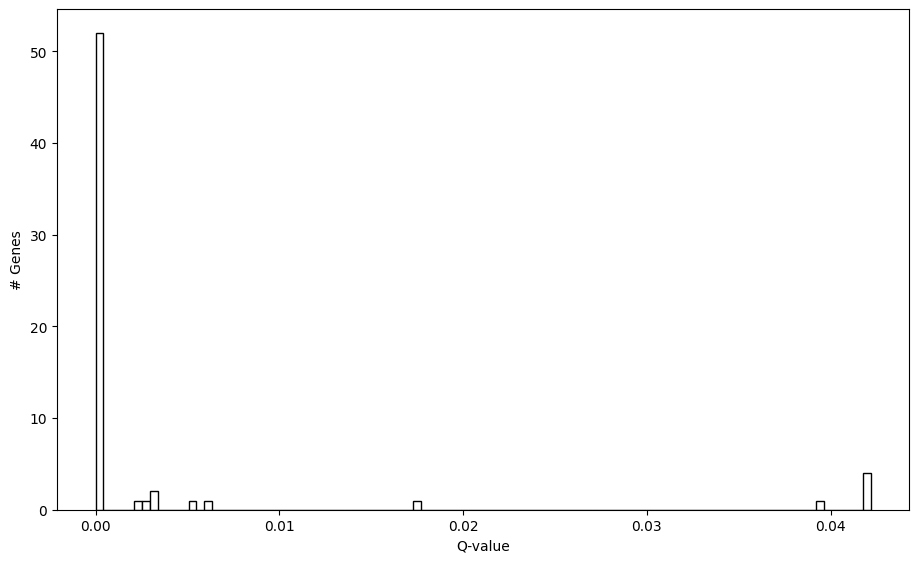

In [3]:
import matplotlib.pyplot as plt

adata = ad.read_h5ad(f'/root/autodl-tmp/MultiGPS/notebook/MERFISH/Zhuang-ABCA-1.014_processed.h5ad')
adata_var = adata.var.index.tolist()
sample_info = pd.read_csv(f'/root/autodl-tmp/MultiGPS/notebook/SpatialDE/middle_df_info_1014.csv', index_col=0)
#downsample adata by sample_info's index
adata = adata[adata.obs.index.isin(sample_info.index)]
df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index).iloc[:,:]
results = pd.read_csv(f'/root/autodl-tmp/MultiGPS/notebook/SpatialDE/middle_results_1014.csv', index_col=0)

with open(f'/root/autodl-tmp/MultiGPS/test/Zhuang-2005/index/recon-cls-coordination-seed114514-Zhuang-2005-epoch:999.txt', "r") as f:
    gene_panel = f.readline()
    gene_panel = eval(gene_panel)
    gene_idx = []
    for x in gene_panel:
        try:
            gene_idx.append(adata_var.index(x))
        except:
            pass

results_selected = results.iloc[gene_idx[:64],:].sort_values('qval')
qvals = results_selected['qval'].values
    
qvals /= 13
plt.figure(figsize=(11, 6.5))
plt.hist(qvals, bins=100, color='w', ec='k')
plt.title('')
plt.ylabel('# Genes')
plt.xlabel('Q-value')
plt.show()